In [1]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

import optuna


In [2]:
# Define paths
base_path = '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/'
files = [
    'Combined_accelerometer_80min.csv',
    'Combined_gyroscope_80min.csv',
    'Combined_linear_accelerometer_80min.csv',
    'Combined_magnetometer_80min.csv'
]

In [3]:
# Load and combine the datasets
dataframes = []
sensor_types = ['accelerometer', 'gyroscope', 'linear_accelerometer', 'magnetometer']
sensor_columns = {}
for file, sensor in zip(files, sensor_types):
    df = pd.read_csv(base_path + file)
    sensor_columns[sensor] = [f'{sensor}_{col}' for col in df.columns if col not in ['time', 'label']]
    df = df.rename(columns={col: f'{sensor}_{col}' for col in df.columns if col not in ['time', 'label']})
    dataframes.append(df)

combined_data = pd.concat(dataframes, axis=1)
print("Data successfully loaded and combined.")

# Remove duplicate 'label' columns keeping only the first occurrence
combined_data = combined_data.loc[:, ~combined_data.columns.duplicated()]

# Print first few rows of the combined data
print(combined_data.head())

Data successfully loaded and combined.
   time  accelerometer_X (m/s^2)  accelerometer_Y (m/s^2)  \
0   0.0                 9.986539                -0.004582   
1   0.5                 5.105301                -0.415617   
2   1.0                 8.871006                -2.852091   
3   1.5                 8.871006                -5.486469   
4   2.0                 9.990088                -5.486469   

   accelerometer_Z (m/s^2)      label  gyroscope_X (rad/s)  \
0                 0.850397  handshake            -0.351920   
1                 0.850397  handshake             0.100001   
2                 0.976863  handshake             0.392478   
3                 1.202958  handshake             0.049560   
4                 1.151986  handshake             0.057486   

   gyroscope_Y (rad/s)  gyroscope_Z (rad/s)  linear_accelerometer_X (m/s^2)  \
0            -0.527611             0.563546                        0.985623   
1            -0.372286            -0.199083                    

In [4]:
# Assuming the target column is named 'label' and is present in all files
target = 'label'

# Define feature columns (excluding time and target columns)
feature_columns = combined_data.columns.difference(['time', target])

# Ensure there are no NaN values
combined_data.dropna(inplace=True)

# Split the data into features and target
X = combined_data[feature_columns]
y = combined_data[target]


Accuracy: 0.9561


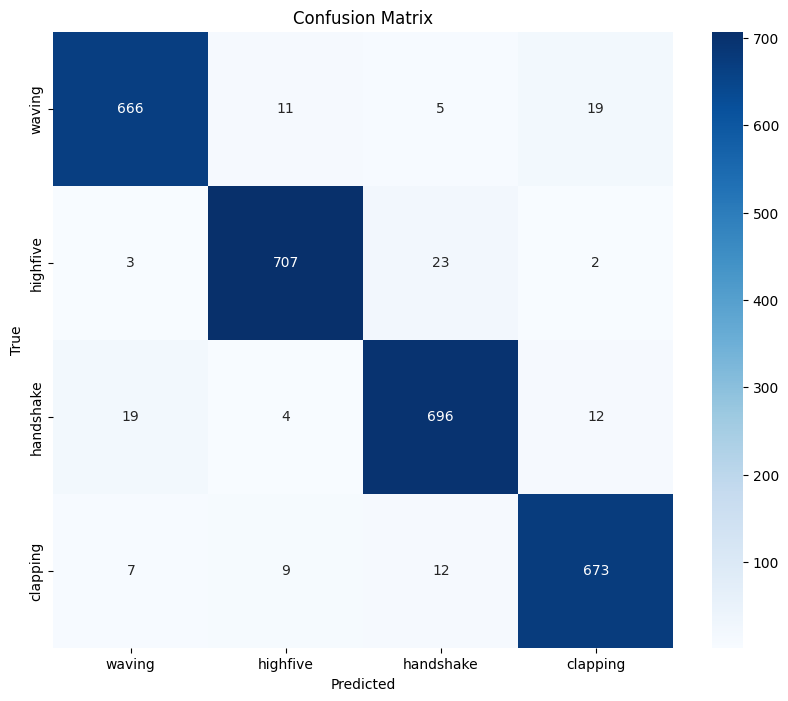

Classification Report:
              precision    recall  f1-score   support

    clapping       0.96      0.95      0.95       701
   handshake       0.97      0.96      0.96       735
    highfive       0.95      0.95      0.95       731
      waving       0.95      0.96      0.96       701

    accuracy                           0.96      2868
   macro avg       0.96      0.96      0.96      2868
weighted avg       0.96      0.96      0.96      2868



In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7777)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=9,
    max_depth=19,
    min_samples_split=3,
    min_samples_leaf=7,
    criterion='log_loss',
    max_features='log2',
    random_state=24
)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
# Plot the confusion matrix with nicer formatting
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y), yticklabels=set(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(class_report)

# Feature importance without feature engineering

In [6]:
def extract_sensor_type(feature_name):
    if 'lin_acc' in feature_name:
        return 'Linear Accelerometer'
    elif 'acc' in feature_name and 'lin' not in feature_name:
        return 'Accelerometer'
    elif 'gyro' in feature_name or 'rad/s' in feature_name:
        return 'Gyroscope'
    elif 'mag' in feature_name or 'µT' in feature_name:
        return 'Magnetometer'
    else:
        return 'Unknown'

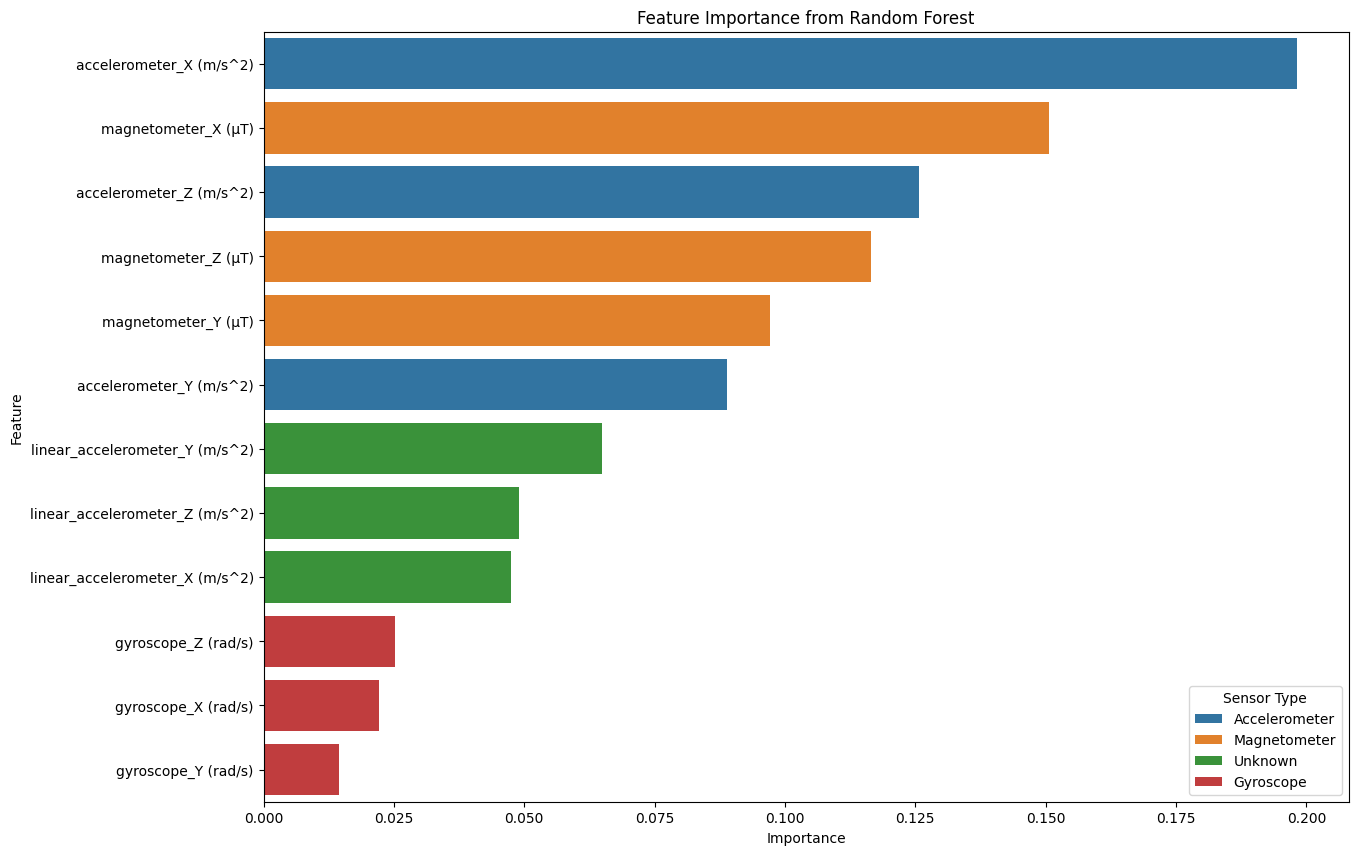

In [7]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Correctly map the feature names to the features used in the model
feature_names = feature_columns.tolist()

# Ensure feature_names matches the actual features used in the model
assert len(feature_names) == len(feature_importances), "Mismatch between feature names and importances lengths."

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Assign sensor type to each feature
importance_df['Sensor'] = importance_df['Feature'].apply(extract_sensor_type)

# Plot feature importances with sensor type indicated
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', hue='Sensor', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend(title='Sensor Type')
plt.show()

## Things to try:
- Try dropping certain columns: magnetometer
- Implement SHAP
- Pick random points (20%) for validation 
- Collect more train/test data
- In LSTM add F1 score as metric, not acc
- Additive feature model creation

# With Feature Engineering

In [8]:
accelerometer_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_accelerometer_80min.csv')
gyroscope_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_gyroscope_80min.csv')
linear_accelerometer_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_linear_accelerometer_80min.csv')
magnetometer_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_magnetometer_80min.csv')


Accuracy: 0.9822


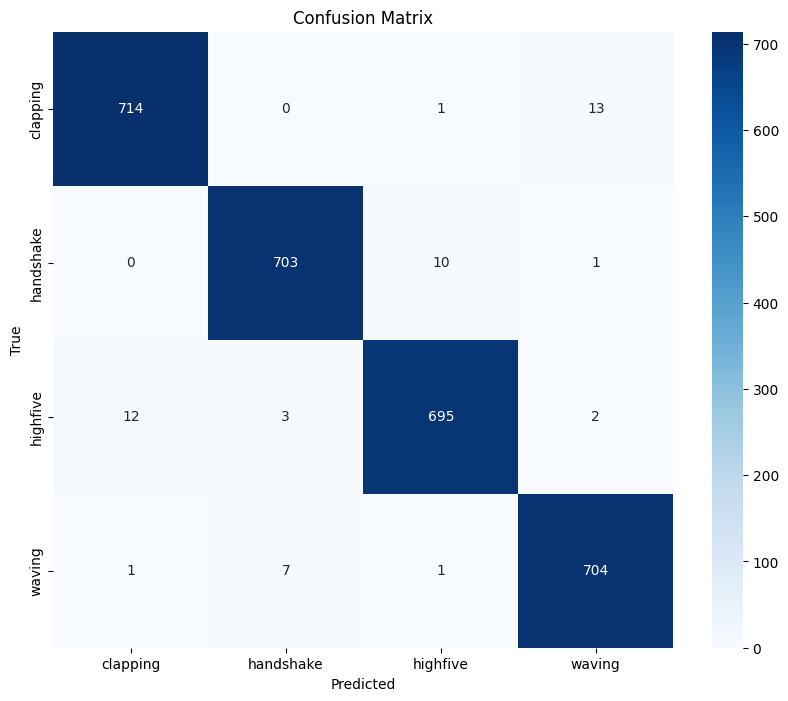

Classification Report:
              precision    recall  f1-score   support

    clapping       0.98      0.98      0.98       728
   handshake       0.99      0.98      0.99       714
    highfive       0.98      0.98      0.98       712
      waving       0.98      0.99      0.98       713

    accuracy                           0.98      2867
   macro avg       0.98      0.98      0.98      2867
weighted avg       0.98      0.98      0.98      2867

Cross-validation scores: [0.79968619 0.97540555 0.97069597 0.81946625 0.9733124 ]
Mean cross-validation score: 0.9077


In [9]:
# Function to add lagged features and rolling statistics
def add_time_features(df, lags, rolling_windows):
    for feature in df.columns:
        if feature not in ['time', 'label']:
            for lag in lags:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
            for window in rolling_windows:
                df[f'{feature}_rolling_mean_{window}'] = df[feature].rolling(window=window).mean()
                df[f'{feature}_rolling_std_{window}'] = df[feature].rolling(window=window).std()
                df[f'{feature}_ewma'] = df[feature].ewm(span=10).mean()
    return df

# Example lags and rolling windows
lags = [3]
rolling_windows = [5]

# Combine all data into one dataframe
combined_data = pd.merge(accelerometer_data, gyroscope_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_data = pd.merge(combined_data, linear_accelerometer_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_data = pd.merge(combined_data, magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))

# Add time-based features
combined_data = add_time_features(combined_data, lags, rolling_windows)

# Drop rows with NaN values generated by lagging and rolling
combined_data.dropna(inplace=True)

# Encode labels
label_encoder = LabelEncoder()
combined_data['label_encoded'] = label_encoder.fit_transform(combined_data['label'])

# Update feature columns after adding new features
feature_columns = combined_data.columns.difference(['time', 'label', 'label_encoded'])

# Split the data into features and target
X = combined_data[feature_columns]
y = combined_data['label_encoded']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=24)

# Initialize and train the Random Forest model
rf_model_rolling = RandomForestClassifier(
    n_estimators=9,
    max_depth=19,
    min_samples_split=3,
    min_samples_leaf=7,
    criterion='log_loss',
    max_features='log2',
    random_state=24
)
rf_model_rolling.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model_rolling.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy:.4f}")
# Plot the confusion matrix with nicer formatting
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(class_report)

# Cross-validation scores
cv_scores = cross_val_score(rf_model_rolling, X_scaled, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")


In [10]:
# Correcting the sensor type extraction function to include all cases for accelerometer, gyroscope, linear accelerometer, and magnetometer
def extract_sensor_type(feature_name):
    if 'X (m/s^2)' in feature_name or 'Y (m/s^2)' in feature_name or 'Z (m/s^2)' in feature_name:
        if 'lin_acc' in feature_name:
            return 'Linear Accelerometer'
        else:
            return 'Accelerometer'
    elif 'acc' in feature_name and 'lin' not in feature_name:
        return 'Accelerometer'
    elif 'gyro' in feature_name or 'rad/s' in feature_name:
        return 'Gyroscope'
    elif 'lin_acc' in feature_name:
        return 'Linear Accelerometer'
    elif 'µT' in feature_name:
        return 'Magnetometer'
    else:
        return 'Unknown'


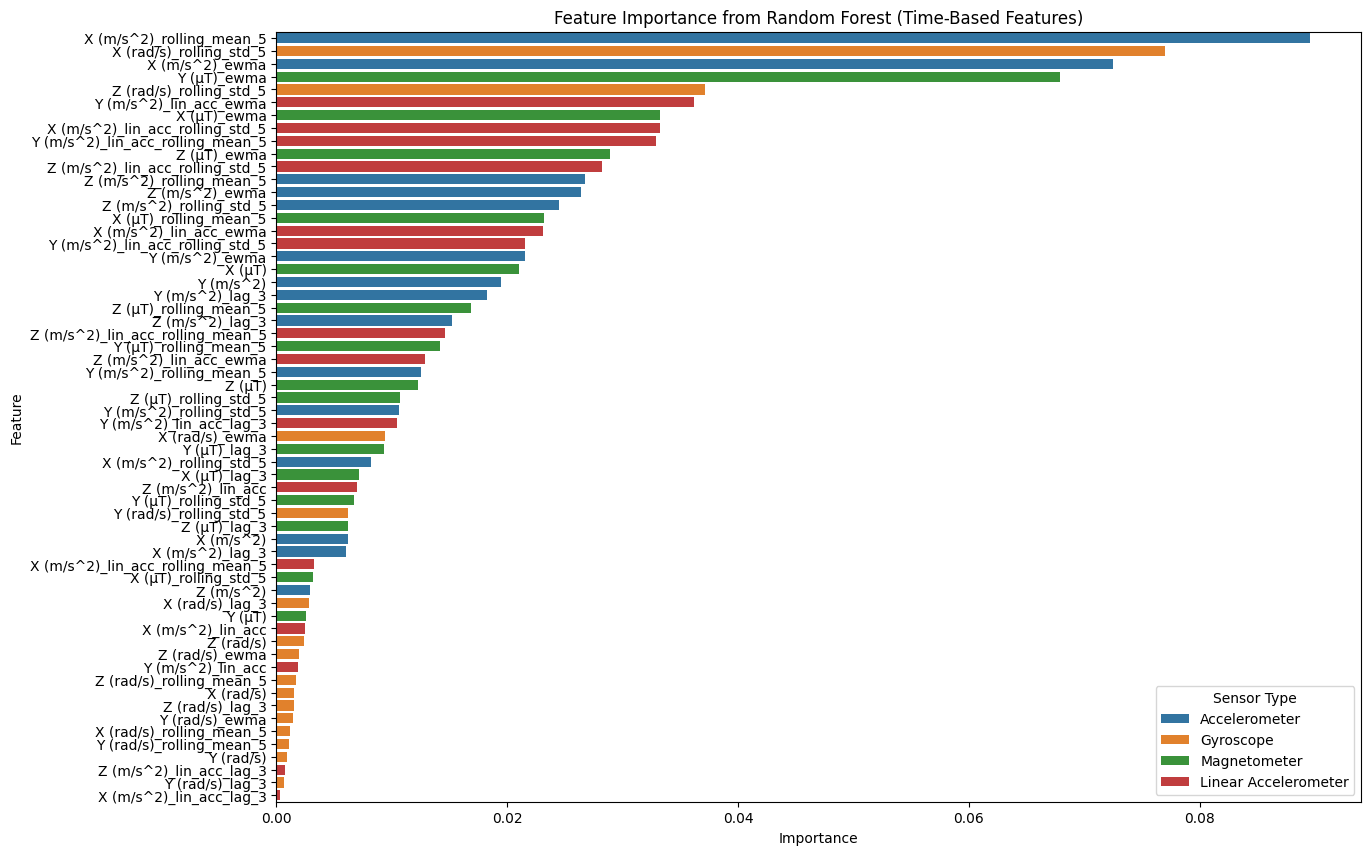

In [11]:
# Get feature importances
feature_importances = rf_model_rolling.feature_importances_

# Ensure feature_names matches the actual features used in the model
feature_names = feature_columns.tolist()
assert len(feature_names) == len(feature_importances), "Mismatch between feature names and importances lengths."

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
# Correct sensor type extraction function
importance_df['Sensor'] = importance_df['Feature'].apply(extract_sensor_type)

# Plot feature importances with sensor type indicated
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', hue='Sensor', data=importance_df)
plt.title('Feature Importance from Random Forest (Time-Based Features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend(title='Sensor Type')
plt.show()

# Fourier Transform Feature Engineering

In [12]:
# Load each dataset
accelerometer_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_accelerometer_80min.csv')
gyroscope_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_gyroscope_80min.csv')
linear_accelerometer_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_linear_accelerometer_80min.csv')
magnetometer_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_magnetometer_80min.csv')


merged_data = pd.merge(accelerometer_data, gyroscope_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
merged_data = pd.merge(merged_data, linear_accelerometer_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
merged_data = pd.merge(merged_data, magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))

In [13]:
# Function to compute FFT features for each column and ensure proper label alignment
def compute_fft_features_correct(data, columns):
    fft_features = {}
    min_len = len(data)
    for col in columns:
        fft_vals = fft(data[col].values)
        fft_vals = fft_vals[:min_len]  # Ensure all FFT values are of the same length
        fft_features[f'{col}_fft_real'] = np.real(fft_vals)
        fft_features[f'{col}_fft_imag'] = np.imag(fft_vals)
        fft_features[f'{col}_fft_abs'] = np.abs(fft_vals)
    return pd.DataFrame(fft_features)

# Select the columns to compute FFT features
sensor_columns = [col for col in merged_data.columns if col not in ['time', 'label']]

# Re-compute FFT features for the merged dataset
fft_features_correct = compute_fft_features_correct(merged_data, sensor_columns)

# Combine the FFT features with the original time-domain features
combined_features = pd.concat([merged_data[sensor_columns], fft_features_correct], axis=1)
combined_features['label'] = merged_data['label'][:len(fft_features_correct)]


In [14]:
# Encode the labels
label_encoder = LabelEncoder()
combined_features['label_encoded'] = label_encoder.fit_transform(combined_features['label'])

# Split the data into training and testing sets
X_combined = combined_features.drop(columns=['label', 'label_encoded'])
y_combined = combined_features['label_encoded']
X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=24)

# Train a Random Forest classifier with combined features
rf_classifier_combined = RandomForestClassifier(
    n_estimators=9,
    max_depth=19,
    min_samples_split=3,
    min_samples_leaf=7,
    criterion='log_loss',
    max_features='log2',
    random_state=24
)
rf_classifier_combined.fit(X_combined_train, y_combined_train)

# Make predictions on the test set
y_combined_pred = rf_classifier_combined.predict(X_combined_test)

In [15]:
# Evaluate the model
accuracy_combined = accuracy_score(y_combined_test, y_combined_pred)
classification_rep_combined = classification_report(y_combined_test, y_combined_pred, target_names=label_encoder.classes_)


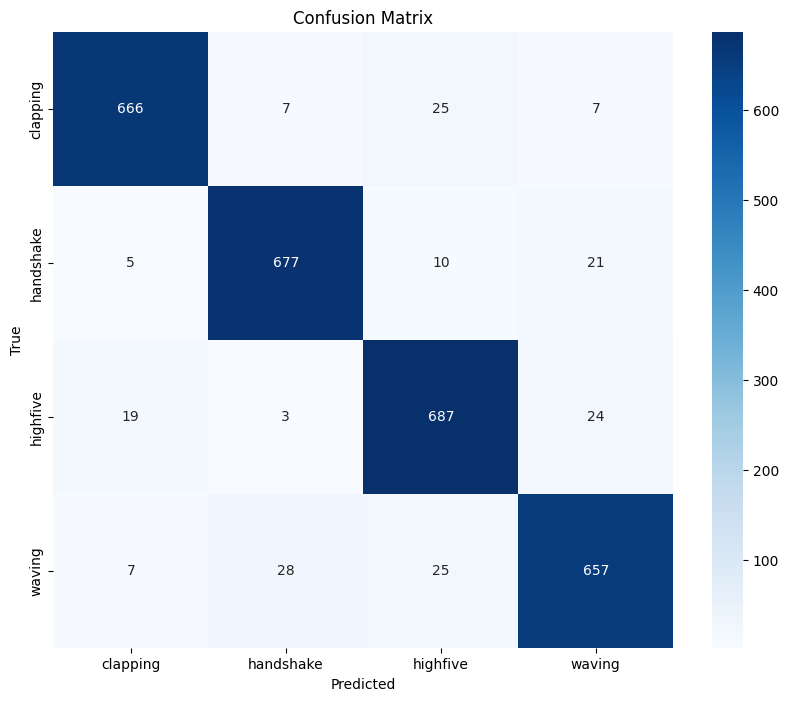

Accuracy: 0.9369
Classification Report:
              precision    recall  f1-score   support

    clapping       0.96      0.94      0.95       705
   handshake       0.95      0.95      0.95       713
    highfive       0.92      0.94      0.93       733
      waving       0.93      0.92      0.92       717

    accuracy                           0.94      2868
   macro avg       0.94      0.94      0.94      2868
weighted avg       0.94      0.94      0.94      2868



In [16]:
# Compute confusion matrix
conf_matrix_combined = confusion_matrix(y_combined_test, y_combined_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_combined, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report and accuracy
print(f"Accuracy: {accuracy_combined:.4f}")
print("Classification Report:")
print(classification_rep_combined)

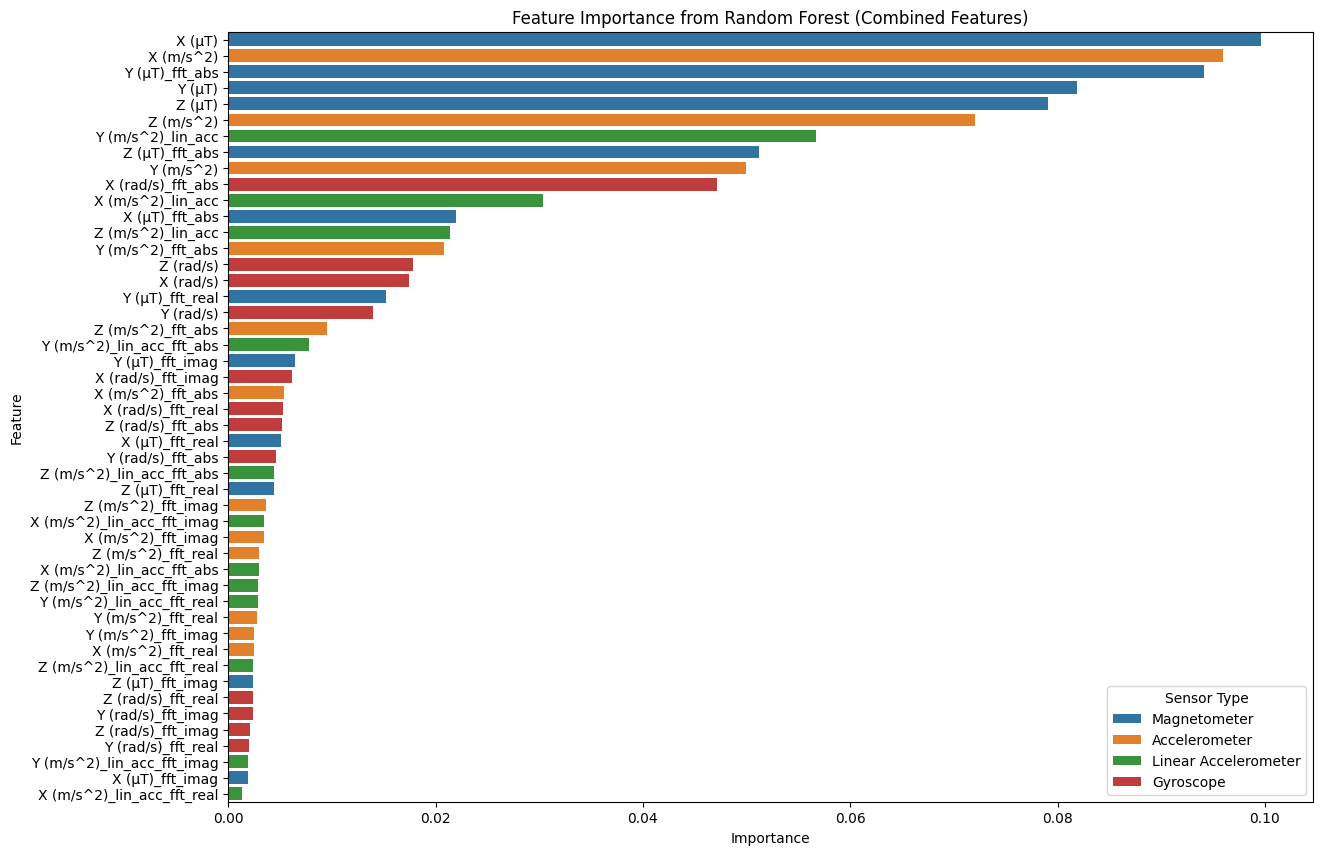

In [17]:

# Get feature importances
feature_importances_combined = rf_classifier_combined.feature_importances_

# Create a DataFrame for visualization
feature_names_combined = X_combined.columns.tolist()
importance_df_combined = pd.DataFrame({'Feature': feature_names_combined, 'Importance': feature_importances_combined})
importance_df_combined = importance_df_combined.sort_values(by='Importance', ascending=False)


importance_df_combined['Sensor'] = importance_df_combined['Feature'].apply(extract_sensor_type)

# Plot feature importances with sensor type indicated
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', hue='Sensor', data=importance_df_combined)
plt.title('Feature Importance from Random Forest (Combined Features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend(title='Sensor Type')
plt.show()


# HyperParameter Optimisation

In [18]:


# Load each dataset
accelerometer_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_accelerometer_80min.csv')
gyroscope_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_gyroscope_80min.csv')
linear_accelerometer_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_linear_accelerometer_80min.csv')
magnetometer_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_80min_data/Combined_magnetometer_80min.csv')

# Combine all data into one dataframe
combined_data = pd.merge(accelerometer_data, gyroscope_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_data = pd.merge(combined_data, linear_accelerometer_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_data = pd.merge(combined_data, magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))

# Remove duplicate 'label' columns keeping only the first occurrence
combined_data = combined_data.loc[:, ~combined_data.columns.duplicated()]

# Ensure there are no NaN values
combined_data.dropna(inplace=True)

# Assuming the target column is named 'label' and is present in all files
target = 'label'

# Define feature columns (excluding time and target columns)
feature_columns = combined_data.columns.difference(['time', target])

# Function to perform the split for each gesture type
def split_gesture_data(data, label, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Ensure the ratios sum to 1
    assert train_ratio + val_ratio + test_ratio == 1.0
    
    gesture_data = data[data[target] == label]
    n = len(gesture_data)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    train_data = gesture_data[:train_end]
    val_data = gesture_data[train_end:val_end]
    test_data = gesture_data[val_end:]
    
    return train_data, val_data, test_data

# Get unique gestures
gestures = combined_data[target].unique()

# Initialize empty dataframes for train, validation, and test sets
train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

# Split each gesture's data and combine them
for gesture in gestures:
    train_gesture, val_gesture, test_gesture = split_gesture_data(combined_data, gesture)
    train_data = pd.concat([train_data, train_gesture])
    val_data = pd.concat([val_data, val_gesture])
    test_data = pd.concat([test_data, test_gesture])

# Split the data into features and target
X_train = train_data[feature_columns]
y_train = train_data[target]
X_val = val_data[feature_columns]
y_val = val_data[target]
X_test = test_data[feature_columns]
y_test = test_data[target]

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyper-parameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 50),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(**params, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = rf_model.predict(X_val)
    
    # Calculate F1 score
    f1 = f1_score(y_val, y_pred, average='macro')
    
    return f1

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best hyper-parameters
best_params = study.best_params
print("Best hyper-parameters: ", best_params)

# Train the final model using the best hyper-parameters on the combined training and validation set
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Predict on the test set
final_predictions = final_model.predict(X_test)

# Evaluate the model
final_f1 = f1_score(y_test, final_predictions, average='weighted')
final_conf_matrix = confusion_matrix(y_test, final_predictions)
final_class_report = classification_report(y_test, final_predictions)

# Output the results
print(f"Final F1 Score: {final_f1:.4f}")
print("Confusion Matrix:")
print(final_conf_matrix)
print("Classification Report:")
print(final_class_report)


[I 2024-06-13 11:30:05,417] A new study created in memory with name: no-name-7dc949b8-48ea-4209-a86f-b4f8a8e6ab50
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2024-06-13 11:30:05,484] Trial 0 finished with value: 0.30404999225454316 and parameters: {'n_estimators': 6, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 11, 'criterion': 'entropy', 'max_features': 'auto'}. Best is trial 0 with value: 0.30404999225454316.
[I 2024-06-13 11:30:05,667] Trial 1 finished with value: 0.2829749510099015 and parameters: {'n_estimators': 25, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 18, 'criterion': 'log_loss', 'max_features': 'log2'}. Best is trial 0 with value: 

[I 2024-06-13 11:30:09,655] Trial 20 finished with value: 0.319403491998003 and parameters: {'n_estimators': 19, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'log_loss', 'max_features': 'sqrt'}. Best is trial 4 with value: 0.3406256417589902.
[I 2024-06-13 11:30:10,042] Trial 21 finished with value: 0.33093992414902873 and parameters: {'n_estimators': 43, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'log_loss', 'max_features': 'sqrt'}. Best is trial 4 with value: 0.3406256417589902.
[I 2024-06-13 11:30:10,417] Trial 22 finished with value: 0.316269302490065 and parameters: {'n_estimators': 42, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'log_loss', 'max_features': 'sqrt'}. Best is trial 4 with value: 0.3406256417589902.
[I 2024-06-13 11:30:10,748] Trial 23 finished with value: 0.32123853419406345 and parameters: {'n_estimators': 37, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf

[I 2024-06-13 11:30:16,747] Trial 46 finished with value: 0.3381636990728314 and parameters: {'n_estimators': 8, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 8, 'criterion': 'log_loss', 'max_features': 'log2'}. Best is trial 41 with value: 0.3822866221565517.
[I 2024-06-13 11:30:16,837] Trial 47 finished with value: 0.327198529487198 and parameters: {'n_estimators': 11, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 10, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 41 with value: 0.3822866221565517.
[I 2024-06-13 11:30:16,903] Trial 48 finished with value: 0.33329738496591643 and parameters: {'n_estimators': 6, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 7, 'criterion': 'log_loss', 'max_features': 'log2'}. Best is trial 41 with value: 0.3822866221565517.
[I 2024-06-13 11:30:17,029] Trial 49 finished with value: 0.3578324733288546 and parameters: {'n_estimators': 13, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_lea

[I 2024-06-13 11:30:20,216] Trial 76 finished with value: 0.3316492283252709 and parameters: {'n_estimators': 8, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 5, 'criterion': 'log_loss', 'max_features': 'log2'}. Best is trial 41 with value: 0.3822866221565517.
[I 2024-06-13 11:30:20,315] Trial 77 finished with value: 0.31866939399795713 and parameters: {'n_estimators': 10, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 9, 'criterion': 'log_loss', 'max_features': 'log2'}. Best is trial 41 with value: 0.3822866221565517.
[I 2024-06-13 11:30:20,373] Trial 78 finished with value: 0.33541562499237254 and parameters: {'n_estimators': 5, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 6, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 41 with value: 0.3822866221565517.
[I 2024-06-13 11:30:20,489] Trial 79 finished with value: 0.3542463065149076 and parameters: {'n_estimators': 12, 'max_depth': 19, 'min_samples_split': 15, 'min_sample

Best hyper-parameters:  {'n_estimators': 5, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'log_loss', 'max_features': 'sqrt'}
Final F1 Score: 0.9009
Confusion Matrix:
[[358   0   3   0]
 [  0 356   4   0]
 [ 14   0 320  26]
 [  6   0  88 261]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.95      0.99      0.97       361
   handshake       1.00      0.99      0.99       360
    highfive       0.77      0.89      0.83       360
      waving       0.91      0.74      0.81       355

    accuracy                           0.90      1436
   macro avg       0.91      0.90      0.90      1436
weighted avg       0.91      0.90      0.90      1436

